# Model Evaluation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from pathlib import Path
cudnn.benchmark = True
plt.ion()   # interactive mode
from tqdm import tqdm
import torchvision.models as models
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix as sk_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
from collections import Counter
import cv2
from torchvision.transforms import ToTensor
from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [85]:
data_transforms = {
    'Train_sorted': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validation_sorted': transforms.Compose([
        transforms.Resize((256, 256)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test_sorted': transforms.Compose([
        transforms.Resize((256, 256)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '/Users/inescocco/Desktop/ISIC2019'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Train_sorted', 'Validation_sorted', 'Test_sorted']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=0)
              for x in ['Train_sorted', 'Validation_sorted', 'Test_sorted']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train_sorted', 'Validation_sorted', 'Test_sorted']}
class_names = image_datasets['Train_sorted'].classes
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to the required size
    transforms.ToTensor(),         # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])



['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


# Evaluation Metrics

In [88]:
def load_history(model_path):
    # Loading the training history
    history = torch.load(model_path)
    #model = model.to(device)  # Move model to the device


    # Printing the keys to see what was saved
    #printing(history.keys())
    
    # Extracting loss and accuracy history
    train_loss = history.get('train_loss', [])
    train_acc = history.get('train_acc', [])
    val_loss = history.get('val_loss', [])
    val_acc = history.get('val_acc', [])
    
    # Printing some values
    print(f"Training Loss: {train_loss}")
    print(f"Training Accuracy: {train_acc}")
    print(f"Validation Loss: {val_loss}")
    print(f"Validation Accuracy: {val_acc}")

In [246]:
def plot_training_curves(history_path):
    """
    Loads training history from a .pth file and plots training/validation accuracy first, then loss.

    Args:
        history_path (str): Path to the training history file (e.g., "training_history_b7.pth").
    """
    # Loading the training history
    history = torch.load(history_path)

    # Extracting training and validation metrics
    train_loss = history.get('train_loss', [])
    val_loss = history.get('val_loss', [])
    train_acc = history.get('train_acc', [])
    val_acc = history.get('val_acc', [])
    
    epochs = range(1, len(train_loss) + 1)

    # Setting figure size
    plt.figure(figsize=(12, 5))

    # Plotting Accuracy First
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label="Training Accuracy", linestyle='-', color="red")
    plt.plot(epochs, val_acc, label="Validation Accuracy", linestyle=':', color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend(fontsize = 11)

    # Plotting Loss Second
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label="Training Loss", linestyle='-', color="red")
    plt.plot(epochs, val_loss, label="Validation Loss", linestyle=':', color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend(fontsize = 11)

    plt.show()


In [248]:
def plot_training_curves2(history_paths, model_names):
    """
    Plots training and validation accuracy (solid lines) and loss (dotted lines) 
    for multiple models on the same graph.

    Args:
        history_paths (dict): A dictionary with model names as keys and their history file paths as values.
        model_names (list): A list of model names in the same order as history_paths keys.
    """
    
    plt.figure(figsize=(12, 5))

    # Defining colors for different models
    colors = ['blue', 'green', 'orange']

    # Plotting Accuracy (Solid Lines)
    plt.subplot(1, 2, 1)
    for i, model in enumerate(model_names):
        history = torch.load(history_paths[model])
        epochs = range(1, len(history['train_acc']) + 1)
        
        plt.plot(epochs, history['train_acc'], linestyle='-', color=colors[i], label=f"{model} Training Acc")
        plt.plot(epochs, history['val_acc'], linestyle=':', color=colors[i], alpha=0.6, label=f"{model} Validation Acc")

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend(fontsize=11)

    # Plotting Loss (Dotted Lines)
    plt.subplot(1, 2, 2)
    for i, model in enumerate(model_names):
        history = torch.load(history_paths[model])
        epochs = range(1, len(history['train_loss']) + 1)
        
        plt.plot(epochs, history['train_loss'], linestyle='-', color=colors[i], label=f"{model} Training Loss")
        plt.plot(epochs, history['val_loss'], linestyle=':', color=colors[i], alpha=0.6, label=f"{model} Validation Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend(fontsize=11)

    plt.show()

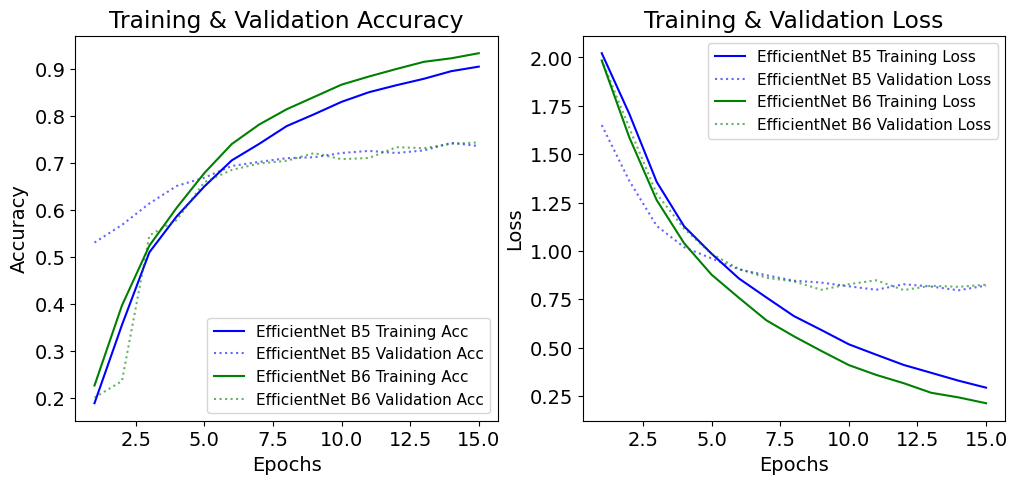

In [254]:
history_files = {
    "EfficientNet B5": "training_history_b5_epoch_14_1.pth",
    "EfficientNet B6": "training_history_b6_epoch_15_3.pth"
}

plot_training_curves2(history_files, ["EfficientNet B5", "EfficientNet B6"])


In [271]:
def evaluate_model(model_path, class_names, device):
    """
    Evaluate the model using various metrics and display the confusion matrix.
    """
    # Initialising DataLoader
    test_dir = '/Users/inescocco/Desktop/ISIC2019/Test_sorted'
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
    
    # Loading the entire model (architecture + weights)
    model = torch.load(model_path, weights_only=False)
    model = model.to(device)  # Move model to the device

    # Setting the model to evaluation mode
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Processing Batches", unit="batch"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Computing confusion matrix
    cm_matrix = sk_confusion_matrix(all_labels, all_preds)  # Use sklearn's confusion_matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_matrix, display_labels=class_names)
    plt.figure(figsize=(12, 8)) 
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Computing additional evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print("\nEvaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1 Score (Weighted): {f1:.4f}")

    # Generating the classification report
    report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0, output_dict=True)

    # Converting the classification report to a DataFrame for better visualization
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.round(4)
    
    # Plotting the classification report as a heatmap with gradient coloring
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :-1].astype(float), annot=True, cmap='Blues', fmt='.4f', cbar=True, annot_kws={"size": 14})
    plt.title("Classification Report", fontsize=16)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()

    # Printing detailed classification report
    print("\nDetailed Classification Report:")
    print(report_df)
    evaluate_model_with_auc(model_path, class_names, device)

In [262]:
def plot_roc_auc(y_true, y_pred_probs, class_names):
    """
    Plots the ROC Curve and computes the AUC for each class.
    
    Args:
    - y_true (list or array): True class labels.
    - y_pred_probs (array): Predicted probabilities for each class.
    - class_names (list): List of class names.
    """
    n_classes = len(class_names)
    
    # One-hot encoding true labels
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    plt.figure(figsize=(8, 6))
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')
    
    # Plotting settings
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.50)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Skin Lesion Multi-Class Classification")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

def evaluate_model_with_auc(model_path, class_names, device):
    """
    Evaluates the model, computes performance metrics, and plots AUC-ROC curves.
    
    Args:
    - model_path (str): Path to the saved model file.
    - class_names (list): List of class names.
    - device (str): 'cuda' or 'cpu'.
    """
    test_dir = '/Users/inescocco/Desktop/ISIC2019/Test_sorted'
    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Load model
    model = torch.load(model_path, weights_only=False)
    model = model.to(device)
    model.eval()

    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Processing Batches", unit="batch"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)  # Convert logits to probabilities
            _, preds = torch.max(probs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Converting lists to NumPy arrays
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Calling the ROC-AUC function
    plot_roc_auc(all_labels, all_probs, class_names)


## Model 1

## Run 1

Training Loss: [1.587334486482348, 0.9459538603540582, 0.6672416413846468, 0.4877129681298219, 0.3750075099288087, 0.2859546438953382]
Training Accuracy: [tensor(0.4427, dtype=torch.float64), tensor(0.6692, dtype=torch.float64), tensor(0.7654, dtype=torch.float64), tensor(0.8310, dtype=torch.float64), tensor(0.8716, dtype=torch.float64), tensor(0.9045, dtype=torch.float64)]
Validation Loss: [1.0447089303167243, 0.8430008590848822, 0.7619582035667017, 0.724035548787368, 0.6845950991229007, 0.6826625573635101]
Validation Accuracy: [tensor(0.6350, dtype=torch.float64), tensor(0.6897, dtype=torch.float64), tensor(0.7161, dtype=torch.float64), tensor(0.7274, dtype=torch.float64), tensor(0.7497, dtype=torch.float64), tensor(0.7479, dtype=torch.float64)]


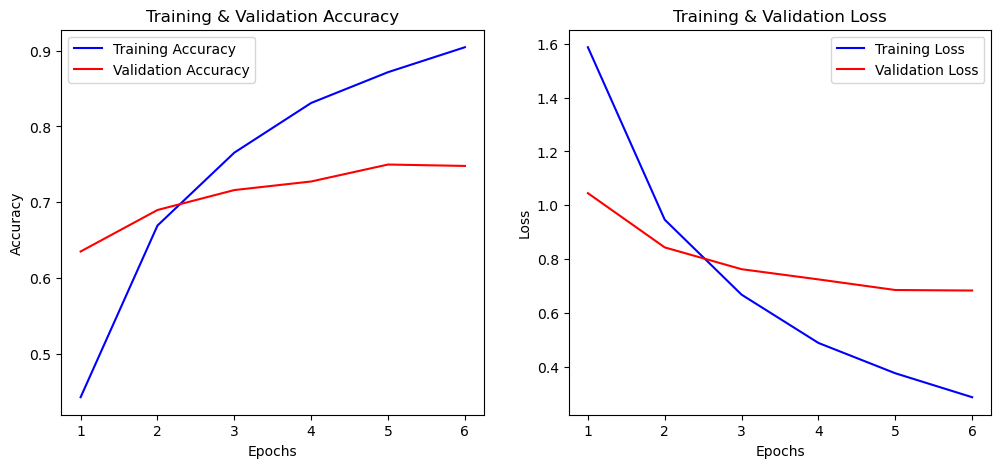

In [32]:
history_path = 'training_history_b7_epoch_5.pth'
load_history(history_path)
plot_training_curves(history_path)

Training Loss: [0.9415484382023444, 0.36538457536319147, 0.1936612894123009, 0.11406728176690055, 0.07722999456304276, 0.03972138474937293, 0.0293767542098595, 0.02281804911086837, 0.024421552272805753, 0.017668462206377154, 0.014023328729486105, 0.011037104824025533, 0.009955579856279213, 0.01112765739968324, 0.008276591593881458]
Training Accuracy: [tensor(0.6666, dtype=torch.float64), tensor(0.8741, dtype=torch.float64), tensor(0.9354, dtype=torch.float64), tensor(0.9616, dtype=torch.float64), tensor(0.9749, dtype=torch.float64), tensor(0.9876, dtype=torch.float64), tensor(0.9912, dtype=torch.float64), tensor(0.9930, dtype=torch.float64), tensor(0.9926, dtype=torch.float64), tensor(0.9947, dtype=torch.float64), tensor(0.9956, dtype=torch.float64), tensor(0.9963, dtype=torch.float64), tensor(0.9970, dtype=torch.float64), tensor(0.9967, dtype=torch.float64), tensor(0.9975, dtype=torch.float64)]
Validation Loss: [0.7368266405557331, 0.644561004136738, 0.6610692811012268, 0.734186904744

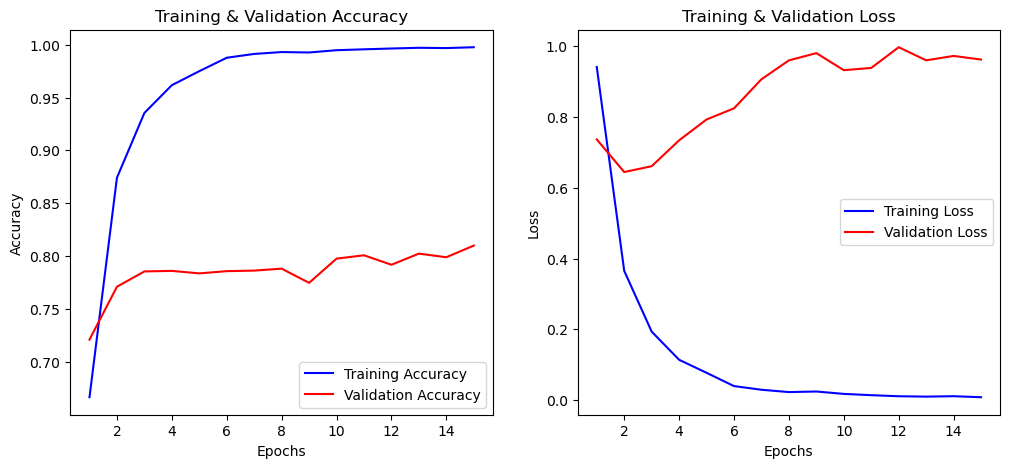

In [62]:
history_path = 'training_history_b7_full_1.pth'
load_history(history_path)
plot_training_curves(history_path)

In [ ]:
# Run confusion matrix
model_path = 'pytorch_finetuned_b7_full_1.pth'
evaluate_model(
    model_path=model_path,  # Use the full model file
    class_names=class_names,
    device=device
)

In [ ]:
model_path = 'pytorch_finetuned_b7_full_1.pth'
evaluate_model_with_auc(model_path, class_names, device)

## Run 2

Training Loss: [1.587334486482348, 0.9459538603540582, 0.6672416413846468, 0.4877129681298219, 0.3750075099288087, 0.2859546438953382, 0.22751283171629513, 0.17559320891927602, 0.14020547116514367, 0.10860530381787364, 0.08971689914636921, 0.07380276597594543, 0.06425519234922288, 0.05359376993197592, 0.05056224006678159]
Training Accuracy: [tensor(0.4427, dtype=torch.float64), tensor(0.6692, dtype=torch.float64), tensor(0.7654, dtype=torch.float64), tensor(0.8310, dtype=torch.float64), tensor(0.8716, dtype=torch.float64), tensor(0.9045, dtype=torch.float64), tensor(0.9230, dtype=torch.float64), tensor(0.9432, dtype=torch.float64), tensor(0.9546, dtype=torch.float64), tensor(0.9660, dtype=torch.float64), tensor(0.9728, dtype=torch.float64), tensor(0.9767, dtype=torch.float64), tensor(0.9805, dtype=torch.float64), tensor(0.9828, dtype=torch.float64), tensor(0.9844, dtype=torch.float64)]
Validation Loss: [1.0447089303167243, 0.8430008590848822, 0.7619582035667017, 0.724035548787368, 0.68

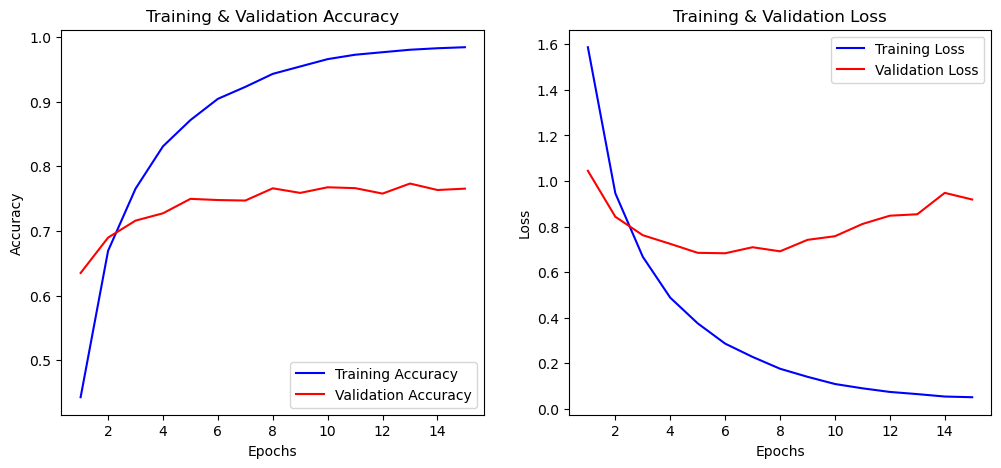

In [34]:
history_path = 'training_history_b7_2.pth'
load_history(history_path)
plot_training_curves(history_path)

In [ ]:
model_path = 'best_model_b7_2.pth'
evaluate_model(
    model_path=model_path,  # Use the full model file
    class_names=class_names,
    device=device
)

## Run 3

Training Loss: [0.9299817682754996, 0.3617281348162295, 0.19579629025277542, 0.11523271756836181, 0.07310368096754936, 0.05477457558791298, 0.043802449894837614]
Training Accuracy: [tensor(0.6697, dtype=torch.float64), tensor(0.8754, dtype=torch.float64), tensor(0.9333, dtype=torch.float64), tensor(0.9607, dtype=torch.float64), tensor(0.9763, dtype=torch.float64), tensor(0.9826, dtype=torch.float64), tensor(0.9852, dtype=torch.float64)]
Validation Loss: [0.7527609592989871, 0.6517044566806994, 0.6669538112063157, 0.7817026265043961, 0.7826930855449877, 0.8610222280652899, 0.8616048383712769]
Validation Accuracy: [tensor(0.7155, dtype=torch.float64), tensor(0.7584, dtype=torch.float64), tensor(0.7703, dtype=torch.float64), tensor(0.7642, dtype=torch.float64), tensor(0.7805, dtype=torch.float64), tensor(0.7792, dtype=torch.float64), tensor(0.7774, dtype=torch.float64)]


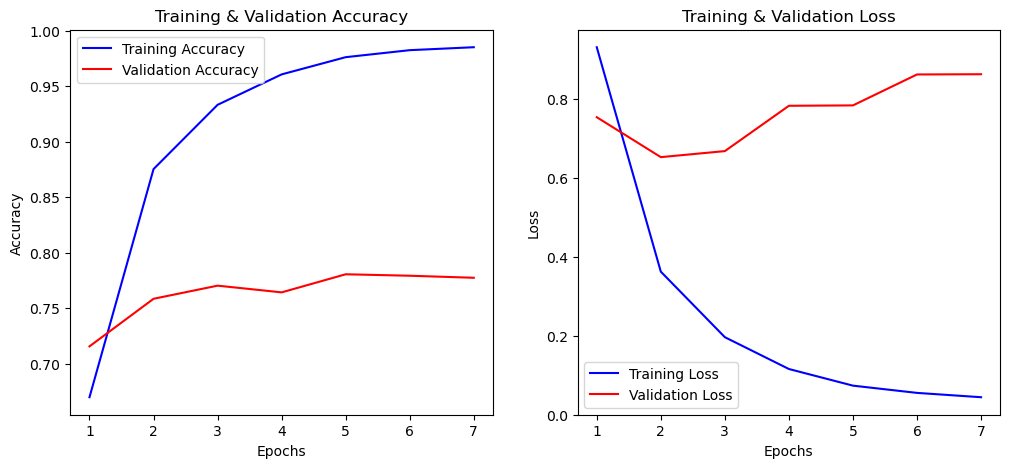

In [54]:
history_path2 = "training_history_b7_epoch_7_3.pth"
load_history(history_path2)
plot_training_curves(history_path2)

# Best Model B7 (WINDOWS 4)

Training Loss: [0.786489251929927, 0.29828063886824013, 0.15921536523625396, 0.09327025248304222, 0.07261236872660252, 0.05750838613739118, 0.046434014330501136]
Training Accuracy: [tensor(0.7204, dtype=torch.float64), tensor(0.8946, dtype=torch.float64), tensor(0.9457, dtype=torch.float64), tensor(0.9679, dtype=torch.float64), tensor(0.9750, dtype=torch.float64), tensor(0.9810, dtype=torch.float64), tensor(0.9847, dtype=torch.float64)]
Validation Loss: [0.683737080912841, 0.6757088607235958, 0.6853667443676998, 0.775331032401637, 0.9318941955817374, 0.8823451474465822, 0.8697908343139448]
Validation Accuracy: [tensor(0.7463, dtype=torch.float64), tensor(0.7595, dtype=torch.float64), tensor(0.7821, dtype=torch.float64), tensor(0.7600, dtype=torch.float64), tensor(0.7421, dtype=torch.float64), tensor(0.7803, dtype=torch.float64), tensor(0.8008, dtype=torch.float64)]


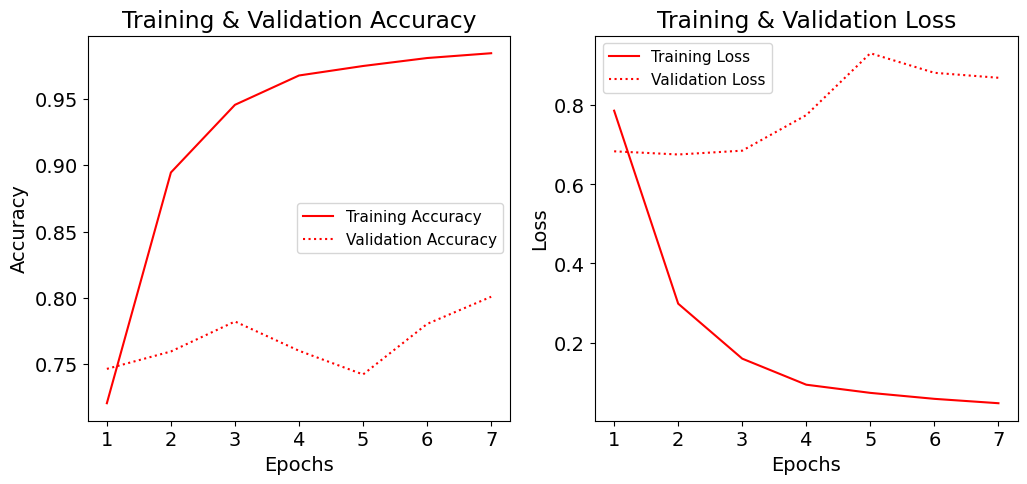

In [256]:
history_path2 = "training_history_b7_2_epoch_7_3.pth"
load_history(history_path2)
plot_training_curves(history_path2)

Processing Batches: 100%|██████████████████| 119/119 [54:01<00:00, 27.24s/batch]


<Figure size 1200x800 with 0 Axes>

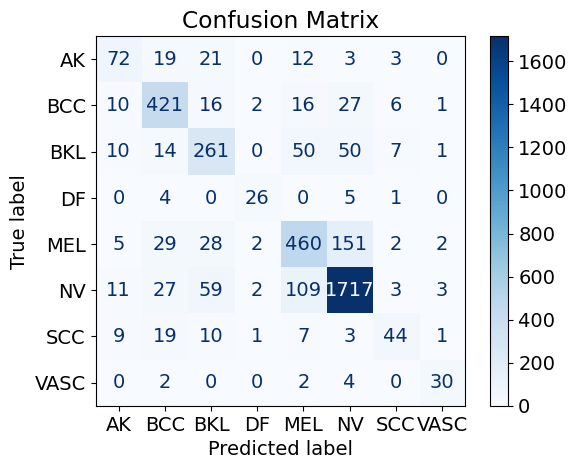


Evaluation Metrics:
Accuracy: 0.7976
Precision (Weighted): 0.7950
Recall (Weighted): 0.7976
F1 Score (Weighted): 0.7956


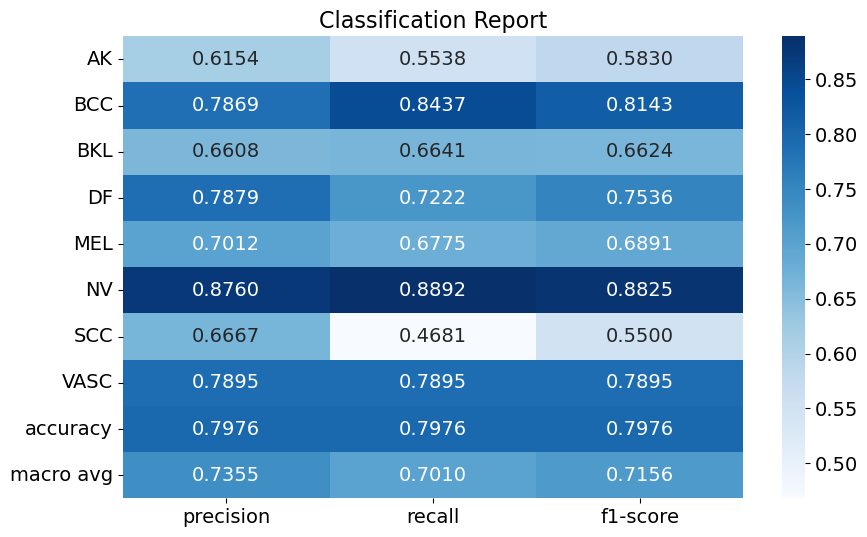


Detailed Classification Report:
              precision  recall  f1-score    support
AK               0.6154  0.5538    0.5830   130.0000
BCC              0.7869  0.8437    0.8143   499.0000
BKL              0.6608  0.6641    0.6624   393.0000
DF               0.7879  0.7222    0.7536    36.0000
MEL              0.7012  0.6775    0.6891   679.0000
NV               0.8760  0.8892    0.8825  1931.0000
SCC              0.6667  0.4681    0.5500    94.0000
VASC             0.7895  0.7895    0.7895    38.0000
accuracy         0.7976  0.7976    0.7976     0.7976
macro avg        0.7355  0.7010    0.7156  3800.0000
weighted avg     0.7950  0.7976    0.7956  3800.0000


Processing Batches: 100%|███████████████| 119/119 [6:32:32<00:00, 197.92s/batch]


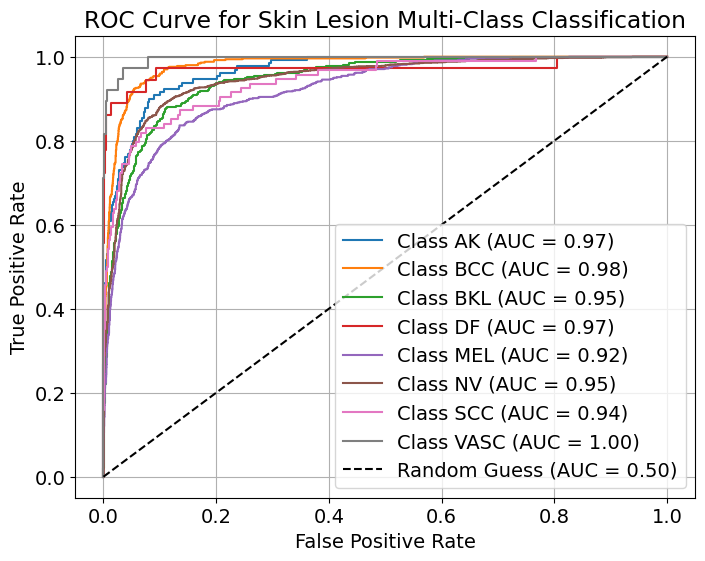

In [282]:
model_path = 'model_b7_2_epoch_7_3.pth'
evaluate_model(
    model_path=model_path,  # Use the full model file
    class_names=class_names,
    device=device
)

## Run 5

Training Loss: [0.9656593012662305, 0.38767584361001733, 0.2363095832234847, 0.16587462692623434, 0.11879670448174526, 0.09767180947979057, 0.082625720513352, 0.07322967988239817]
Training Accuracy: [tensor(0.6569, dtype=torch.float64), tensor(0.8672, dtype=torch.float64), tensor(0.9207, dtype=torch.float64), tensor(0.9440, dtype=torch.float64), tensor(0.9613, dtype=torch.float64), tensor(0.9675, dtype=torch.float64), tensor(0.9740, dtype=torch.float64), tensor(0.9763, dtype=torch.float64)]
Validation Loss: [0.7527431531956321, 0.7531036651761909, 0.6495073590780559, 0.8888534468098691, 0.770367966890335, 0.8014318154360118, 0.8989950139899003, 1.0309079514051738]
Validation Accuracy: [tensor(0.7221, dtype=torch.float64), tensor(0.7245, dtype=torch.float64), tensor(0.7805, dtype=torch.float64), tensor(0.7263, dtype=torch.float64), tensor(0.7879, dtype=torch.float64), tensor(0.7868, dtype=torch.float64), tensor(0.7761, dtype=torch.float64), tensor(0.7505, dtype=torch.float64)]


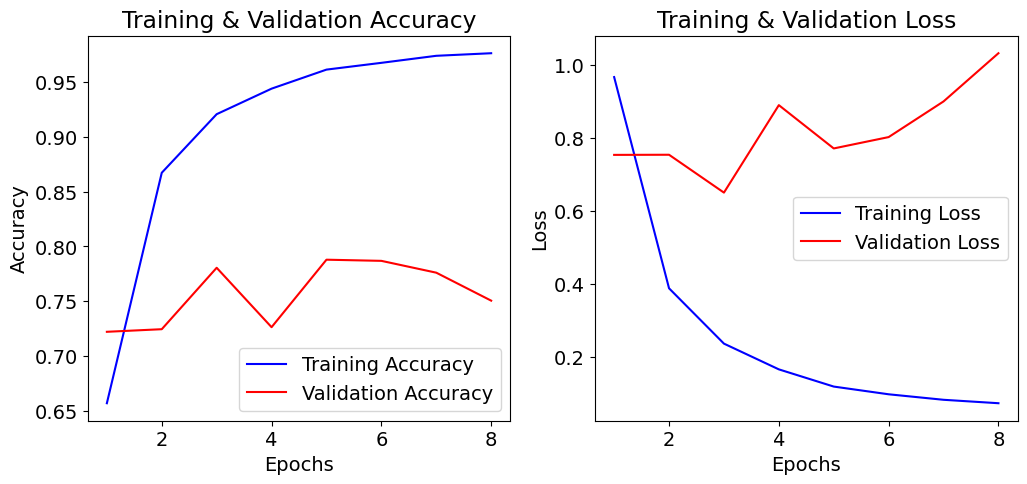

In [200]:
history_path2 = "training_history_b7_epoch_8_5.pth"
load_history(history_path2)
plot_training_curves(history_path2)

# Run 6 (WINDOWS 6)

Training Loss: [1.3943165536207613, 0.620170611015697, 0.34773546452081855, 0.2141786360771113, 0.1439504732697617, 0.10721710710539617, 0.09003987226793736, 0.06832319471955552]
Training Accuracy: [tensor(0.4699, dtype=torch.float64), tensor(0.7846, dtype=torch.float64), tensor(0.8855, dtype=torch.float64), tensor(0.9302, dtype=torch.float64), tensor(0.9540, dtype=torch.float64), tensor(0.9649, dtype=torch.float64), tensor(0.9714, dtype=torch.float64), tensor(0.9790, dtype=torch.float64)]
Validation Loss: [0.8854021703569512, 0.7234576008194371, 0.6873272181812086, 0.8263425934942145, 0.8093988293095639, 0.8700401511945223, 0.954156671856579, 0.9587207488009805]
Validation Accuracy: [tensor(0.6811, dtype=torch.float64), tensor(0.7534, dtype=torch.float64), tensor(0.7647, dtype=torch.float64), tensor(0.7376, dtype=torch.float64), tensor(0.7663, dtype=torch.float64), tensor(0.7832, dtype=torch.float64), tensor(0.7805, dtype=torch.float64), tensor(0.7726, dtype=torch.float64)]


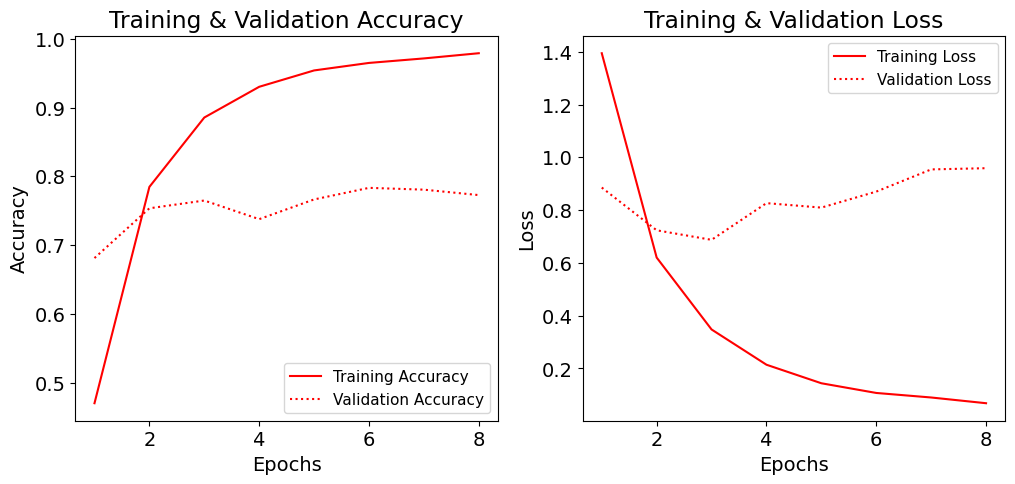

In [284]:
history_path = 'training_history_b7_epoch_8_6.pth'
load_history(history_path)
plot_training_curves(history_path)

Training Loss: [1.922365886096385, 1.4319652864515668, 1.1301390483001768, 0.9319806484869649, 0.7758766006849632, 0.6531428653856027, 0.550155825826807, 0.47611973515823663, 0.40057808293005126, 0.3503285034525359, 0.29324670844771716, 0.2580490943067463, 0.22639256613602013, 0.18723310419198294, 0.17044461468742014, 0.143325838724887]
Training Accuracy: [tensor(0.2626, dtype=torch.float64), tensor(0.4519, dtype=torch.float64), tensor(0.5641, dtype=torch.float64), tensor(0.6490, dtype=torch.float64), tensor(0.7157, dtype=torch.float64), tensor(0.7628, dtype=torch.float64), tensor(0.8046, dtype=torch.float64), tensor(0.8327, dtype=torch.float64), tensor(0.8598, dtype=torch.float64), tensor(0.8781, dtype=torch.float64), tensor(0.8991, dtype=torch.float64), tensor(0.9106, dtype=torch.float64), tensor(0.9241, dtype=torch.float64), tensor(0.9360, dtype=torch.float64), tensor(0.9413, dtype=torch.float64), tensor(0.9525, dtype=torch.float64)]
Validation Loss: [1.2990132673163164, 1.080130370

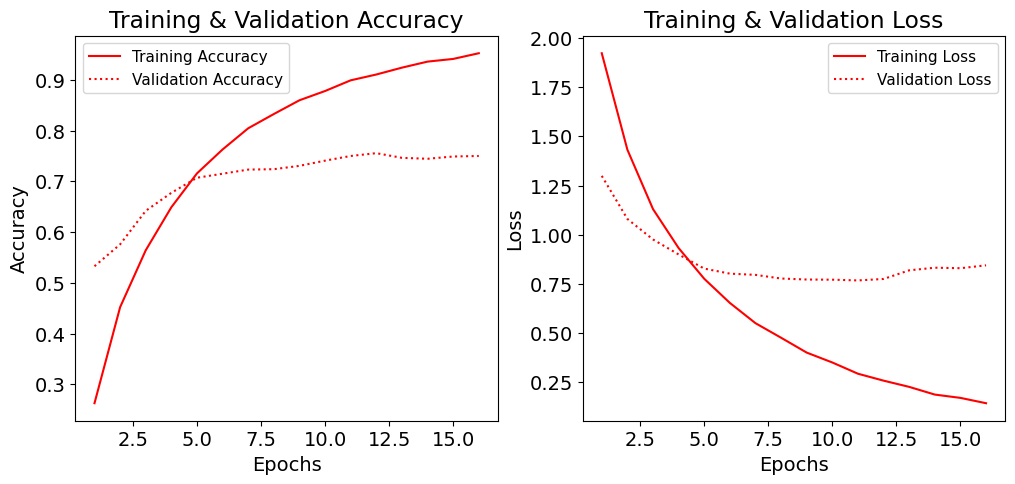

In [297]:
history_path = 'training_history_b6_epoch_16_6.pth'
load_history(history_path)
plot_training_curves(history_path)

## Model 2

### Run 1

Training Loss: [3.7829952642269498, 1.1740015051351436, 0.8682975151199717, 0.6983751135027578, 0.5659047904980058, 0.4637686636025433, 0.42028894530056815, 0.38053381555213117, 0.34565982158448816, 0.3117833880887425, 0.2810541551563169, 0.2687146044299948, 0.2495540862211331, 0.24356983017059192, 0.2316831185708574, 0.22065202728350594, 0.21049767333947064, 0.20802953668213173, 0.2007826697997875, 0.20112265205112442]
Training Accuracy: [tensor(0.3042, dtype=torch.float64), tensor(0.5959, dtype=torch.float64), tensor(0.6938, dtype=torch.float64), tensor(0.7549, dtype=torch.float64), tensor(0.8006, dtype=torch.float64), tensor(0.8393, dtype=torch.float64), tensor(0.8516, dtype=torch.float64), tensor(0.8658, dtype=torch.float64), tensor(0.8802, dtype=torch.float64), tensor(0.8915, dtype=torch.float64), tensor(0.9027, dtype=torch.float64), tensor(0.9069, dtype=torch.float64), tensor(0.9128, dtype=torch.float64), tensor(0.9151, dtype=torch.float64), tensor(0.9201, dtype=torch.float64), t

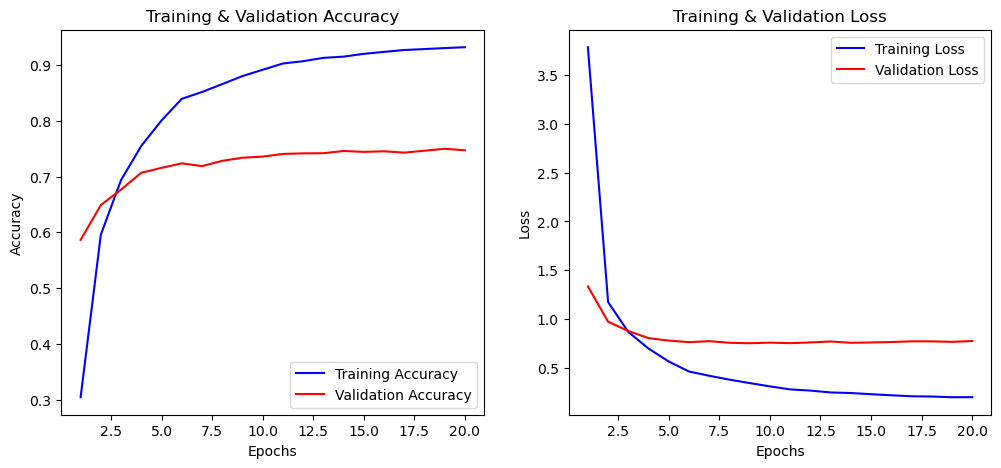

In [69]:
history_path2 = "training_history_b6_full_1.pth"
load_history(history_path2)
plot_training_curves(history_path2)

Processing Batches: 100%|██████████████████| 119/119 [26:18<00:00, 13.26s/batch]


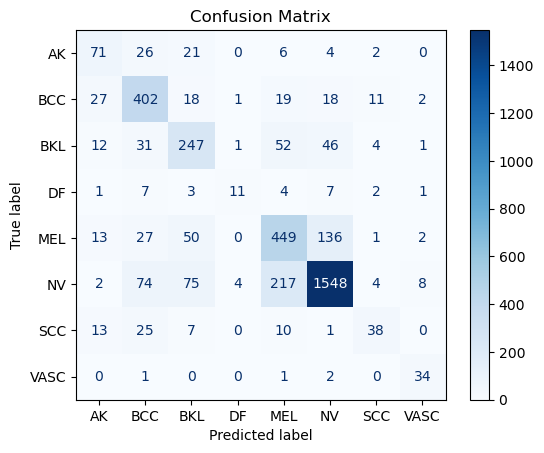


Evaluation Metrics:
Accuracy: 0.7368
Precision (Weighted): 0.7479
Recall (Weighted): 0.7368
F1 Score (Weighted): 0.7391


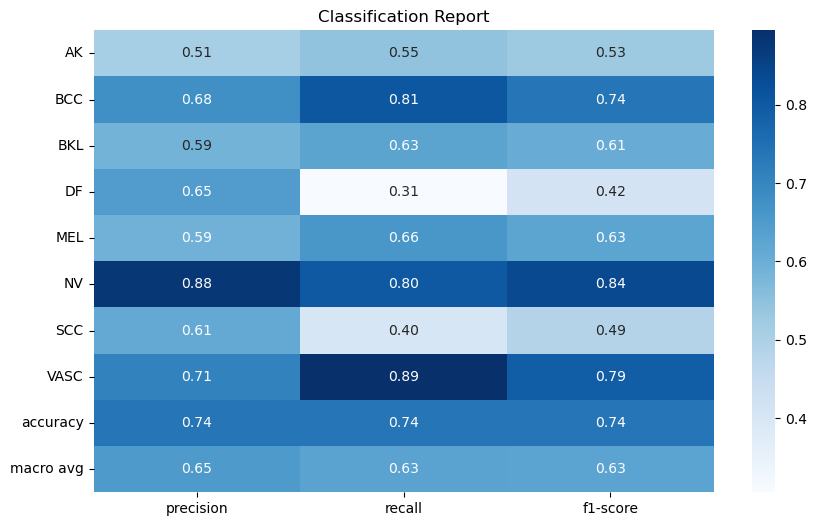


Detailed Classification Report:
              precision    recall  f1-score      support
AK             0.510791  0.546154  0.527881   130.000000
BCC            0.677909  0.807229  0.736939   498.000000
BKL            0.586698  0.626904  0.606135   394.000000
DF             0.647059  0.305556  0.415094    36.000000
MEL            0.592348  0.662242  0.625348   678.000000
NV             0.878547  0.801242  0.838116  1932.000000
SCC            0.612903  0.404255  0.487179    94.000000
VASC           0.708333  0.894737  0.790698    38.000000
accuracy       0.736842  0.736842  0.736842     0.736842
macro avg      0.651824  0.631040  0.628424  3800.000000
weighted avg   0.747881  0.736842  0.739065  3800.000000


In [53]:
# Run confusion matrix
model_path = 'pytorch_finetuned_b6_full_1.pth'
evaluate_model(
    model_path=model_path,  # Use the full model file
    class_names=class_names,
    device=device
)

In [ ]:
evaluate_model_with_auc(model_path2, class_names, device)

### Run 2

Training Loss: [1.9719512659107752, 1.6430949430114385, 1.4247000829350984, 1.195884175151867, 0.9850764410827197, 0.8251085846646559, 0.7007470286783591, 0.6078539454158066, 0.5233251827479242, 0.4509275359759955, 0.393447639649515, 0.3425375655890473, 0.29978224892358557, 0.26143260322196665, 0.2354130779252029, 0.2070190961818023, 0.17850029840364223, 0.15480359854854284, 0.13948994393040492, 0.12447342734947163]
Training Accuracy: [tensor(0.2196, dtype=torch.float64), tensor(0.3901, dtype=torch.float64), tensor(0.4692, dtype=torch.float64), tensor(0.5559, dtype=torch.float64), tensor(0.6463, dtype=torch.float64), tensor(0.7064, dtype=torch.float64), tensor(0.7554, dtype=torch.float64), tensor(0.7905, dtype=torch.float64), tensor(0.8260, dtype=torch.float64), tensor(0.8485, dtype=torch.float64), tensor(0.8718, dtype=torch.float64), tensor(0.8898, dtype=torch.float64), tensor(0.9034, dtype=torch.float64), tensor(0.9170, dtype=torch.float64), tensor(0.9268, dtype=torch.float64), tenso

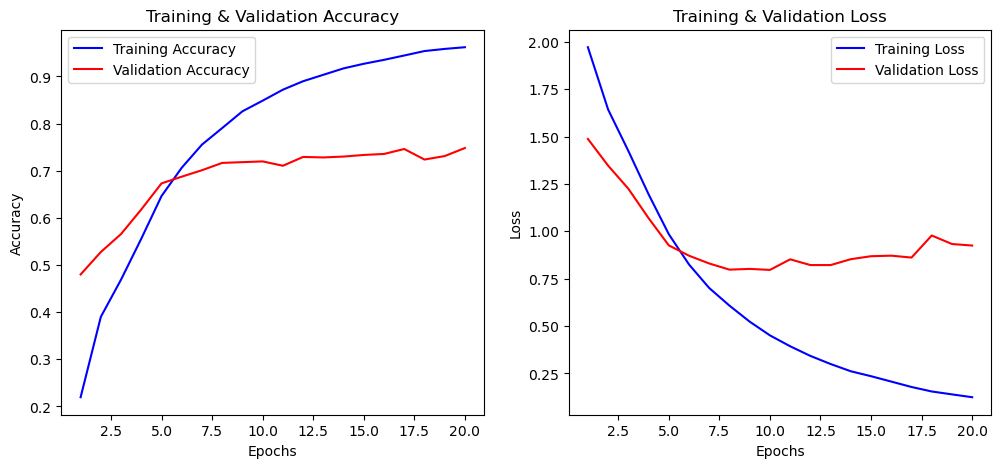

In [23]:
history_path= "training_history_b6_epoch_19_2.pth"
load_history(history_path)
plot_training_curves(history_path)

Training Loss: [1.9719512659107752, 1.6430949430114385, 1.4247000829350984, 1.195884175151867, 0.9850764410827197, 0.8251085846646559, 0.7007470286783591, 0.6078539454158066, 0.5233251827479242, 0.4509275359759955, 0.393447639649515, 0.3425375655890473, 0.29978224892358557, 0.26143260322196665, 0.2354130779252029]
Training Accuracy: [tensor(0.2196, dtype=torch.float64), tensor(0.3901, dtype=torch.float64), tensor(0.4692, dtype=torch.float64), tensor(0.5559, dtype=torch.float64), tensor(0.6463, dtype=torch.float64), tensor(0.7064, dtype=torch.float64), tensor(0.7554, dtype=torch.float64), tensor(0.7905, dtype=torch.float64), tensor(0.8260, dtype=torch.float64), tensor(0.8485, dtype=torch.float64), tensor(0.8718, dtype=torch.float64), tensor(0.8898, dtype=torch.float64), tensor(0.9034, dtype=torch.float64), tensor(0.9170, dtype=torch.float64), tensor(0.9268, dtype=torch.float64)]
Validation Loss: [1.4878879735344335, 1.3469008355391654, 1.2250780562350625, 1.069795443635238, 0.9259845492

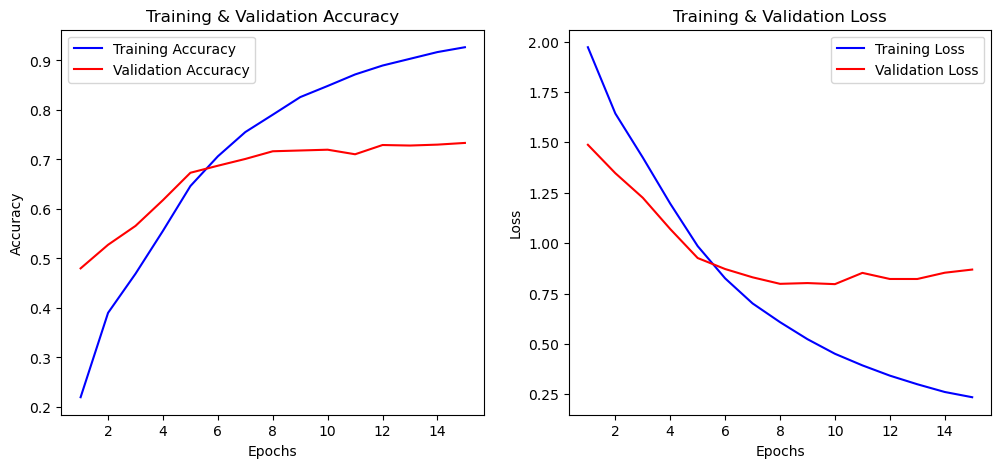

In [81]:
history_path= "training_history_b6_epoch_14_2.pth"
load_history(history_path)
plot_training_curves(history_path)

Processing Batches: 100%|██████████████████| 119/119 [27:04<00:00, 13.65s/batch]


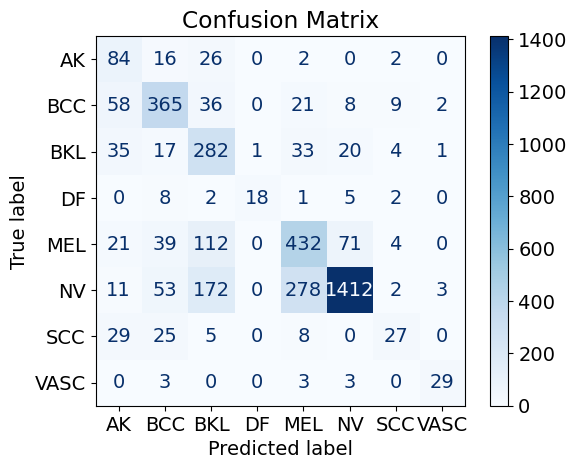


Evaluation Metrics:
Accuracy: 0.6971
Precision (Weighted): 0.7513
Recall (Weighted): 0.6971
F1 Score (Weighted): 0.7112


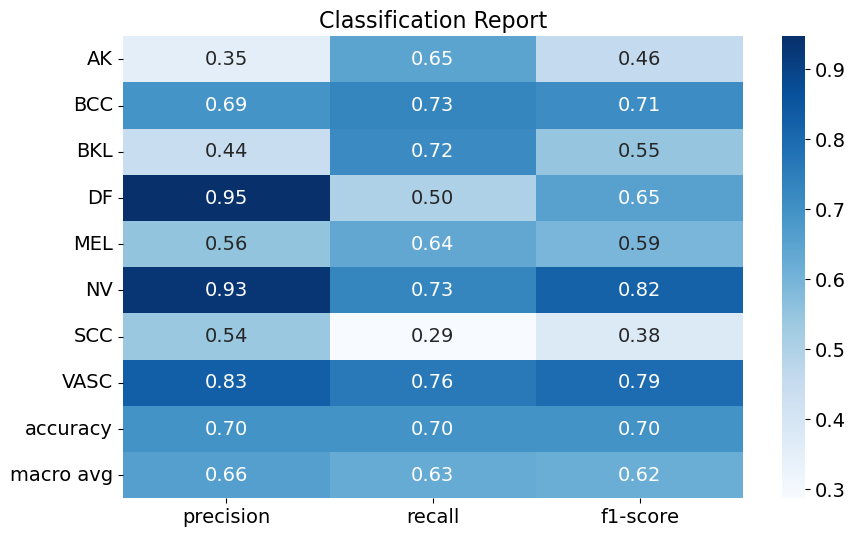


Detailed Classification Report:
              precision    recall  f1-score      support
AK             0.352941  0.646154  0.456522   130.000000
BCC            0.693916  0.731463  0.712195   499.000000
BKL            0.444094  0.717557  0.548638   393.000000
DF             0.947368  0.500000  0.654545    36.000000
MEL            0.555270  0.636230  0.592999   679.000000
NV             0.929559  0.731227  0.818551  1931.000000
SCC            0.540000  0.287234  0.375000    94.000000
VASC           0.828571  0.763158  0.794521    38.000000
accuracy       0.697105  0.697105  0.697105     0.697105
macro avg      0.661465  0.626628  0.619121  3800.000000
weighted avg   0.751325  0.697105  0.711216  3800.000000


Processing Batches: 100%|██████████████████| 119/119 [32:44<00:00, 16.51s/batch]


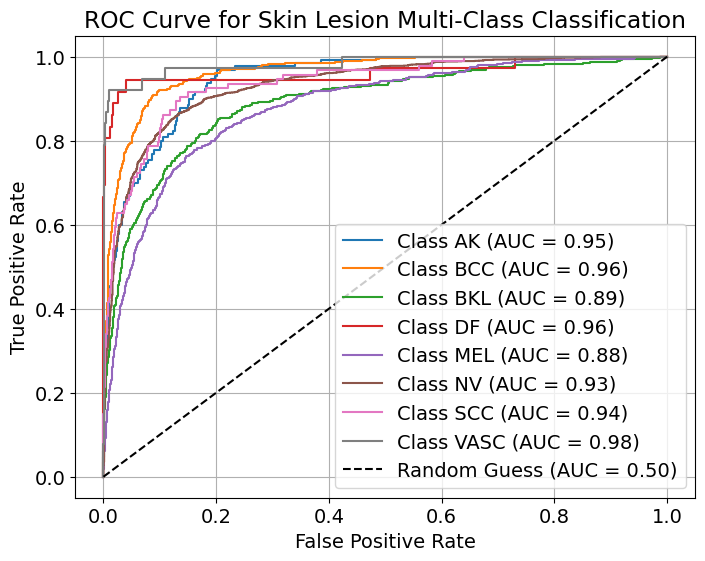

In [181]:
# Run confusion matrix
model_path = 'model_b6_epoch_14_2.pth'
evaluate_model(
    model_path=model_path,  # Use the full model file
    class_names=class_names,
    device=device
)

# Best Model B6

Training Loss: [1.9839658275603222, 1.5880859540206957, 1.2628857798075028, 1.039771579997326, 0.8773176081079923, 0.7571939300965096, 0.6409506345186288, 0.5586400373259613, 0.48284789920654564, 0.40982625611641293, 0.3590561191011225, 0.31621185062905416, 0.26671511885635185, 0.2427596322476912, 0.21272904536245843]
Training Accuracy: [tensor(0.2261, dtype=torch.float64), tensor(0.3962, dtype=torch.float64), tensor(0.5237, dtype=torch.float64), tensor(0.6047, dtype=torch.float64), tensor(0.6780, dtype=torch.float64), tensor(0.7398, dtype=torch.float64), tensor(0.7814, dtype=torch.float64), tensor(0.8138, dtype=torch.float64), tensor(0.8400, dtype=torch.float64), tensor(0.8662, dtype=torch.float64), tensor(0.8836, dtype=torch.float64), tensor(0.8996, dtype=torch.float64), tensor(0.9148, dtype=torch.float64), tensor(0.9223, dtype=torch.float64), tensor(0.9331, dtype=torch.float64)]
Validation Loss: [1.9880409075084486, 1.6374525431582803, 1.2951546094292088, 1.1150185936375667, 0.98473

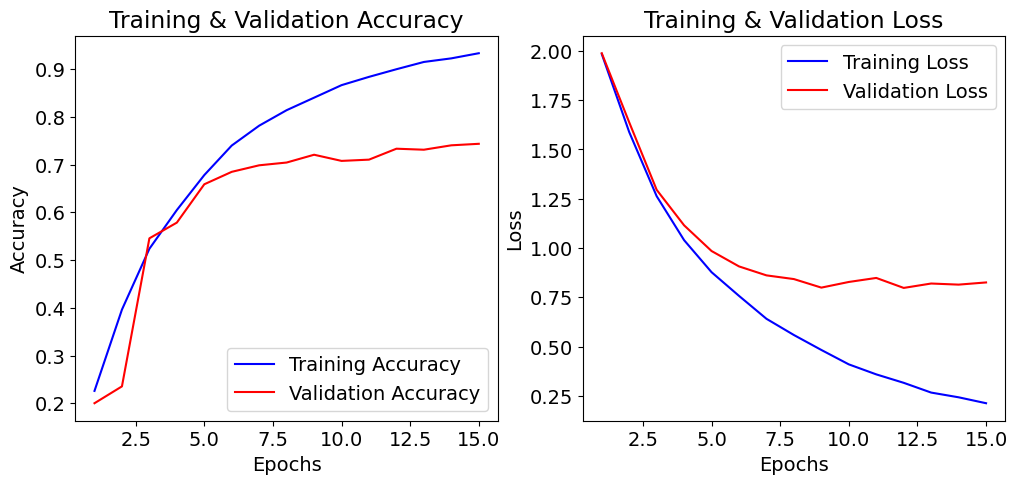

In [190]:
history_path= "training_history_b6_epoch_15_3.pth"
load_history(history_path)
plot_training_curves(history_path)

Processing Batches: 100%|██████████████████| 119/119 [27:30<00:00, 13.87s/batch]


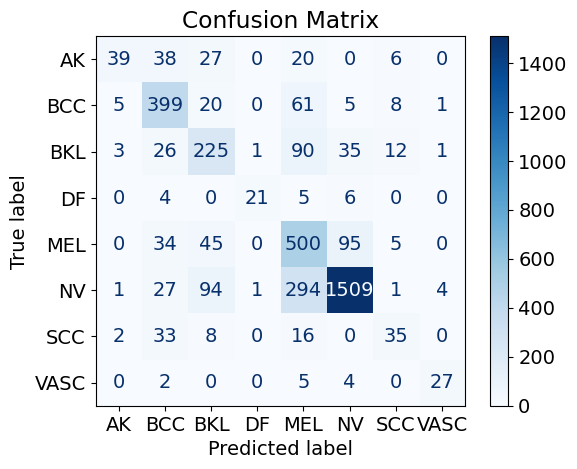


Evaluation Metrics:
Accuracy: 0.7250
Precision (Weighted): 0.7588
Recall (Weighted): 0.7250
F1 Score (Weighted): 0.7307


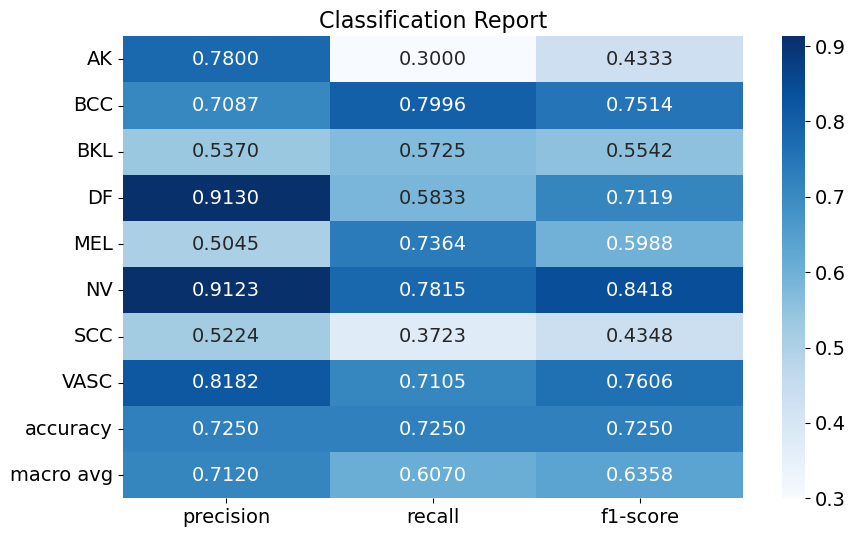


Detailed Classification Report:
              precision  recall  f1-score   support
AK               0.7800  0.3000    0.4333   130.000
BCC              0.7087  0.7996    0.7514   499.000
BKL              0.5370  0.5725    0.5542   393.000
DF               0.9130  0.5833    0.7119    36.000
MEL              0.5045  0.7364    0.5988   679.000
NV               0.9123  0.7815    0.8418  1931.000
SCC              0.5224  0.3723    0.4348    94.000
VASC             0.8182  0.7105    0.7606    38.000
accuracy         0.7250  0.7250    0.7250     0.725
macro avg        0.7120  0.6070    0.6358  3800.000
weighted avg     0.7588  0.7250    0.7307  3800.000


Processing Batches:  78%|██████████████▊    | 93/119 [24:25<06:54, 15.95s/batch]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x111cd5620>
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/Applications/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1582, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Applications/anaconda3/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/anaconda3/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/anaconda3/lib/python3.12/multiprocessing/connection.py", line 1136, in wait
    ready = selector.select(ti

KeyboardInterrupt: 

In [226]:
model_path = 'model_b6_epoch_15_3.pth'
evaluate_model(
    model_path=model_path,  # Use the full model file
    class_names=class_names,
    device=device
)

## windows 6

## Model 3

## Run 1 Best Model B5

Training Loss: [2.021984508711345, 1.709781716766778, 1.3570582244498142, 1.1271520031174846, 0.9857317471767055, 0.8571646684086044, 0.759237398204383, 0.663088302389208, 0.591192642441678, 0.5173208841427451, 0.46341745885157654, 0.41060737272637865, 0.37002073050058154, 0.32916777417300114, 0.29313715628059556]
Training Accuracy: [tensor(0.1884, dtype=torch.float64), tensor(0.3548, dtype=torch.float64), tensor(0.5096, dtype=torch.float64), tensor(0.5863, dtype=torch.float64), tensor(0.6494, dtype=torch.float64), tensor(0.7051, dtype=torch.float64), tensor(0.7402, dtype=torch.float64), tensor(0.7780, dtype=torch.float64), tensor(0.8032, dtype=torch.float64), tensor(0.8296, dtype=torch.float64), tensor(0.8502, dtype=torch.float64), tensor(0.8650, dtype=torch.float64), tensor(0.8787, dtype=torch.float64), tensor(0.8949, dtype=torch.float64), tensor(0.9046, dtype=torch.float64)]
Validation Loss: [1.6506423739383096, 1.363209205175701, 1.1295426883195576, 1.0193748450279236, 0.9610590078

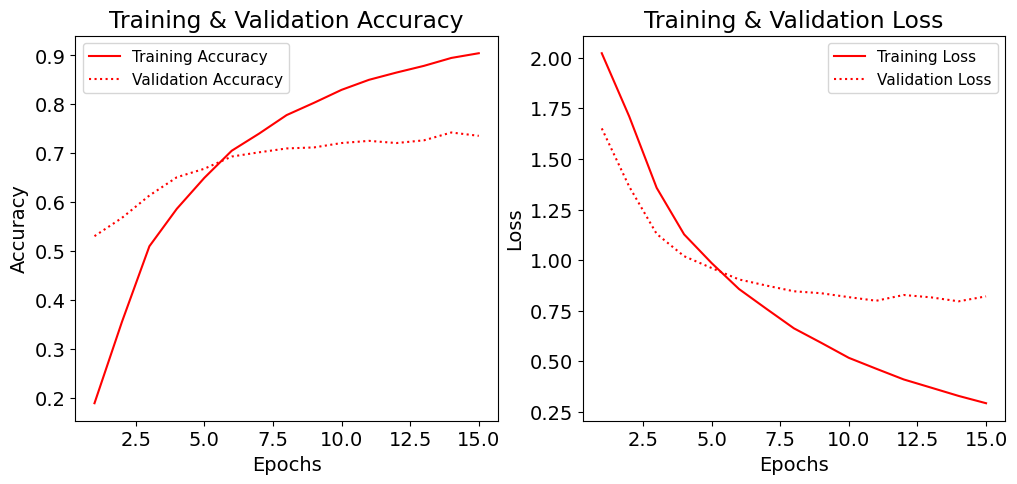

In [280]:
history_path= "training_history_b5_epoch_14_1.pth"
load_history(history_path)
plot_training_curves(history_path)

In [ ]:
# Run confusion matrix
model_path = 'model_b5_epoch_14.pth'
evaluate_model(
    model_path=model_path,  # Use the full model file
    class_names=class_names,
    device=device
)